In [19]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import skimage
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
from torchvision import datasets
from torchvision import transforms as tr
from torchvision.io import read_image
from torchvision import models
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
BATCH_SIZE = 8

In [3]:
from google.colab import drive
drive.mount('/content/drive')


!cp -R '/content/drive/MyDrive/RGBaHa_26-03-23' './RGBaHa_26-03-23'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
data_folder = "./RGBaHa_26-03-23"
images_folder = "RGBaHa"
table_file = "data.csv"
types_file = "types.csv"

In [5]:
target_column = "latin"

In [6]:
class TreeDataset(Dataset):
    def __init__(self, imgs_path, table_path, types_path):
        super().__init__()
        
        self.types = pd.read_csv(types_path, index_col=0)
        self.table = pd.read_csv(table_path, index_col=0, converters={"latin": lambda x: self.types.loc[x].type if x != "NA" else np.nan}).dropna()
        self.label_map = {label: i for i, label in enumerate(self.table.latin.unique())}
        self.table = self.table.replace({"latin": self.label_map})
        
        self.max_h, self.max_w = 0, 0
        self.depth_max = 0
        images = []
        for tree_id in self.table.treeID:
            file_path = os.path.join(imgs_path, f"treeID_{tree_id}.tiff")
            img_rgbd = skimage.io.imread(file_path)[:, :, [0, 1, 2, 4]].transpose(2, 0, 1)[None, :, :, :]
            self.max_h = max(self.max_h, img_rgbd.shape[2])
            self.max_w = max(self.max_w, img_rgbd.shape[3])
            self.depth_max = max(self.depth_max, img_rgbd[:, 3, :, :].max())
            images.append(torch.from_numpy(img_rgbd))
        
        self.channel_mean, self.channel_std = 0, 0
        padded_images = []
        for image in images:
            image[:, :3, :, :] /= 255.
            image[:, 3, :, :] /= self.depth_max
            self.channel_mean += image.mean(dim=(0, 2, 3))
            self.channel_std += image.std(dim=(0, 2, 3))

            img_h, img_w = image.shape[2:]
            h_pos = (self.max_h - img_h) // 2
            w_pos = (self.max_w - img_w) // 2
            padded = torch.zeros(1, 4, self.max_h, self.max_w)
            padded[:, :, h_pos: h_pos+img_h, w_pos: w_pos+img_w] = image
            padded_images.append(padded)            
            
        self.images = torch.cat(padded_images)
        self.channel_mean /= len(self.images)
        self.channel_std /= len(self.images)
        
    def __getitem__(self, index):
        x = self.images[index].type(torch.FloatTensor)
        y = torch.tensor(self.table.iloc[index].loc[target_column], dtype=torch.long)
        return x, y
    
    def __len__(self):
        return len(self.table)

In [7]:
class TreeDatasetFromSubset(Dataset):
    def __init__(self, subset, all_transform=None, rgb_transform=None):
        self.subset = subset
        self.all_transform = all_transform
        self.rgb_transform = rgb_transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.all_transform:
            x = self.all_transform(x)
        if self.rgb_transform:
            x[:3, :, :] = self.rgb_transform(x[:3, :, :])
        return x, y

    def __len__(self):
        return len(self.subset)

In [8]:
data = TreeDataset(os.path.join(data_folder, images_folder), 
                   os.path.join(data_folder, table_file), 
                   os.path.join(data_folder, types_file))

In [9]:
train, val, test = random_split(data, [0.70, 0.20, 0.10])

In [10]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [11]:
all_transform = tr.Compose([
    tr.Normalize(data.channel_mean, data.channel_std),
    tr.RandomHorizontalFlip(),
    tr.RandomVerticalFlip(),
    tr.RandomAffine(degrees=180),
    #tr.RandomApply([AddGaussianNoise(),]),
])
rgb_transform = tr.Compose([
    #tr.RandomAutocontrast(),
    #tr.RandomAdjustSharpness(0.5),
])

prepare_transform = tr.Compose([
    tr.Normalize(data.channel_mean, data.channel_std),
])

In [12]:
train_dataset = TreeDatasetFromSubset(train, all_transform=all_transform, rgb_transform=rgb_transform)
val_dataset = TreeDatasetFromSubset(val, all_transform=prepare_transform)

Targets:
tensor(4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


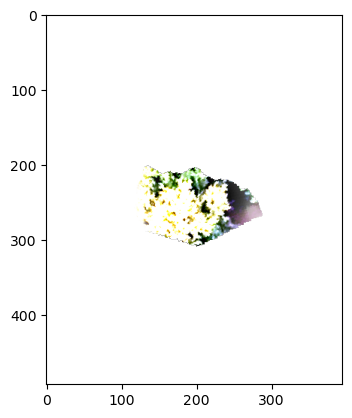

In [13]:
print("Targets:")
idx = np.random.randint(0, 100)
print(train_dataset[idx][1])
plt.imshow(train_dataset[idx][0].movedim(0, -1))
plt.show()

In [14]:
def make_weights_for_balanced_classes(data, indices=None):
    n_images = len(data.table)
    count_per_class = np.bincount(data.table.latin, minlength=len(data.table.latin.unique()))
    weight_per_class = (float(n_images) / count_per_class)
    weights = weight_per_class[data.table.latin]
    if indices:
        weights = weights[indices]
    return torch.tensor(weights)

In [15]:
train_weights = make_weights_for_balanced_classes(train.dataset, train.indices)
train_sampler = WeightedRandomSampler(train_weights, len(train_weights))
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    sampler=train_sampler,
    drop_last=True,
)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
)

In [16]:
class RGBDNet(nn.Module):
    def __init__(self, classes_num, rgb_pretrained=models.efficientnet_v2_s, remaining_layers=1, dropout=0.2):
        super().__init__()

        self.feature_extractor_rgb = rgb_pretrained(weights="DEFAULT")
        for param in self.feature_extractor_rgb.parameters():
            param.requires_grad = True
        self.feature_extractor_d = rgb_pretrained(weights="DEFAULT")
        for param in self.feature_extractor_d.parameters():
            param.requires_grad = True

        embed_size_rgb = self.feature_extractor_rgb.classifier[1].in_features
        embed_size_d = self.feature_extractor_d.classifier[1].in_features

        self.feature_extractor_rgb.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(embed_size_rgb, embed_size_rgb),
            nn.BatchNorm1d(embed_size_rgb),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_size_rgb, embed_size_rgb),
            nn.BatchNorm1d(embed_size_rgb),
            nn.ReLU(),
        )
        self.feature_extractor_d.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(embed_size_d, embed_size_d),
            nn.BatchNorm1d(embed_size_d),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_size_d, embed_size_d),
            nn.BatchNorm1d(embed_size_d),
            nn.ReLU(),
        )

        self.depth_layer = nn.Conv2d(remaining_layers, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        
        final_embed_size = embed_size_rgb + embed_size_d
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(final_embed_size, final_embed_size),
            nn.BatchNorm1d(final_embed_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(final_embed_size, classes_num),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        rgb = x[:, :3, :, :]
        d = x[:, 3:, :, :]

        rgb_embed = self.feature_extractor_rgb(rgb)
        d_embed = self.feature_extractor_d(self.depth_layer(d))
        final_embed = torch.cat((rgb_embed, d_embed), dim=1)

        output = self.classifier(final_embed)
        return output

In [17]:
import IPython


def train_loop(model, dataloader, loss_clf_fn, optimizer, step=0.05, history_loss=None, history_acc=None):
    out = display(IPython.display.Pretty('Learning...'), display_id=True)

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    train_acc = []
    train_loss = []
    percentage = 0
    
    for batch, (X, y_clf) in enumerate(tqdm(dataloader, leave=False, desc="Batch #")):
        torch.cuda.empty_cache()
        gc.collect()
        
        X = X.to(device)
        y_clf = y_clf.to(device)
        pred_clf = model(X)
        loss = loss_clf_fn(pred_clf, y_clf)
        train_acc.append((pred_clf.argmax(1) == y_clf).type(torch.float).mean().item())
        train_loss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch / (num_batches - 1) >= percentage:
            percentage = int(batch / (num_batches - 1) / step) * step
            out.update(f'[{int(percentage * size)}/{size}] Batch NLL Loss: {loss.item():>8f}')
        
    if history_loss is not None:
        history_loss.append(np.mean(train_loss))
    if history_acc is not None:
        history_acc.append(np.mean(train_acc))

    return {'train_loss': np.mean(train_loss), 'train_acc': np.mean(train_acc)}


def test_loop(model, dataloader,  loss_clf_fn, history_loss=None, history_acc=None):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    val_acc = []
    val_loss = []
    correct = 0

    with torch.no_grad():
        for batch, (X, y_clf) in enumerate(tqdm(dataloader, leave=False, desc="Batch #")):
            torch.cuda.empty_cache()
            gc.collect()
        
            X = X.to(device)
            y_clf = y_clf.to(device)
            pred_clf = model(X)
            loss = loss_clf_fn(pred_clf, y_clf)
            val_acc.append((pred_clf.argmax(1) == y_clf).type(torch.float).mean().item())
            val_loss.append(loss.item())
            correct += (pred_clf.argmax(1) == y_clf).type(torch.float).sum().item()

        correct /= size
        total_loss = np.mean(val_loss)
        print(f"Validation accuracy: {(100*correct):>0.1f}%, Validation NLL Loss: {total_loss:>8f} \n")

    if history_loss is not None:
        history_loss.append(total_loss)
    if history_acc is not None:
        history_acc.append(correct)
    
    return {'val_loss': total_loss, 'val_acc': correct}

In [18]:
def plot_learning_process(train_loss, val_loss, title):
    
    fig = plt.figure(figsize=(12, 4))
    
    ax1 = plt.subplot(121)
    ax1.plot(np.arange(0, len(train_loss)) + 1, train_loss, label='train')
    ax1.plot(np.arange(0, len(val_loss)) + 1, val_loss, label='val')
    ax1.legend()
    ax1.grid()
    ax1.set_xlabel('epoch')
    ax1.set_ylabel(title.split()[0])
    ax1.set_title(title)
    
    fig.tight_layout()
    plt.show()

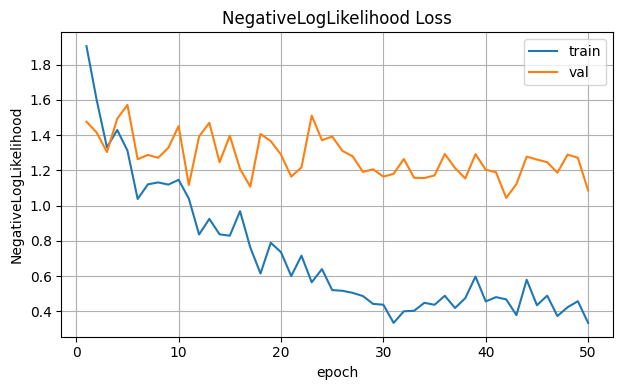

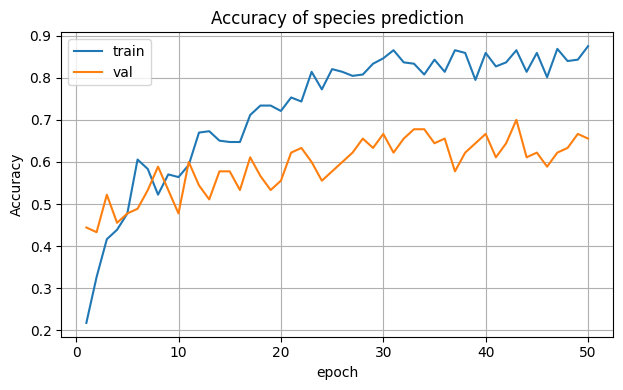

In [20]:
train_label_counts = np.bincount(train.dataset.table.iloc[train.indices].latin.values, minlength=data.table.latin.nunique())
train_label_weights = torch.tensor(train_label_counts / train_label_counts.sum(), dtype=torch.float, device=device)
loss_clf = nn.NLLLoss(train_label_weights)
# loss_clf = nn.NLLLoss()


epochs = 50

models_results = {}
net = RGBDNet(classes_num=len(data.label_map))
net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5, min_lr=1e-7)

train_acc, train_loss = [], []
val_acc, val_loss = [], []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    print("-------------------------------")
    train_loop(net, train_dataloader, loss_clf, optimizer, history_loss=train_loss, history_acc=train_acc)
    test_loop(net, val_dataloader, loss_clf, history_loss=val_loss, history_acc=val_acc)
    scheduler.step(val_loss[-1])
    IPython.display.clear_output()
    plot_learning_process(train_loss, val_loss, "NegativeLogLikelihood Loss")
    plot_learning_process(train_acc, val_acc, "Accuracy of species prediction")

In [21]:
models_results[f"train_{target_column}_acc"] = train_acc
models_results[f"train_{target_column}_loss"] = train_loss
models_results[f"val_{target_column}_acc"] = val_acc
models_results[f"val_{target_column}_loss"] = val_loss

In [22]:
results_df = pd.DataFrame(models_results)

In [23]:
results_df.index.name = "Epoch"
results_df.index = results_df.index + 1
results_df.dropna()

,train_latin_acc,train_latin_loss,val_latin_acc,val_latin_loss
Epoch,,,,
1,0.217949,1.904458,0.444444,1.475981
2,0.326923,1.597736,0.433333,1.413865
3,0.416667,1.329932,0.522222,1.303719
4,0.439103,1.428833,0.455556,1.492558
5,0.477564,1.312076,0.477778,1.571127
6,0.605769,1.037194,0.488889,1.262794
7,0.583333,1.120402,0.533333,1.287326
8,0.522436,1.131141,0.588889,1.270986
9,0.570513,1.118875,0.533333,1.327815


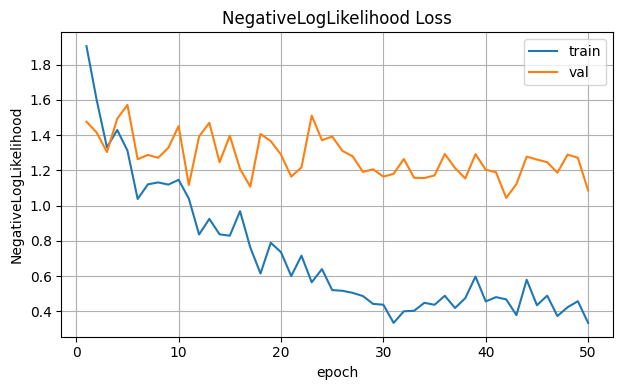

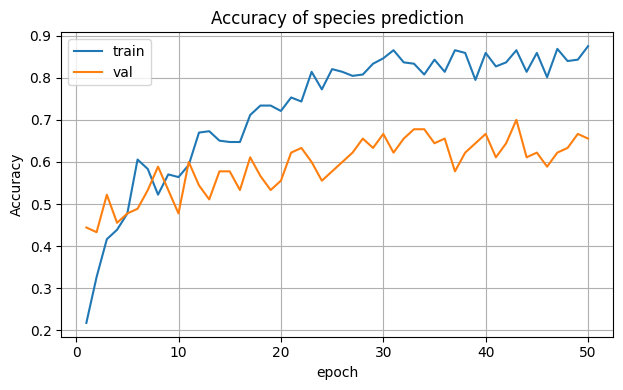

In [24]:
plot_learning_process(results_df.train_latin_loss, results_df.val_latin_loss, "NegativeLogLikelihood Loss")
plot_learning_process(results_df.train_latin_acc, results_df.val_latin_acc, "Accuracy of species prediction")

In [25]:
test_dataset = TreeDatasetFromSubset(test, prepare_transform)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
)

In [26]:
PATH = f"{target_column}_prediction_model.pt"
assert not os.path.exists(PATH), "There is a checkpoint already! Remove this assert to override"
test_results = test_loop(net, test_dataloader, loss_clf)
torch.save({
    'epoch': epochs,
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': test_results["val_loss"],
    'acc': test_results["val_acc"]
},
    PATH)

Batch #:   0%|          | 0/6 [00:00<?, ?it/s]

Validation accuracy: 53.3%, Validation NLL Loss: 1.224237 



In [27]:
# model = RGBDNet(classes_num=len(data.label_map)).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']
# acc = checkpoint['acc']

# model.eval()

In [28]:
from sklearn.metrics import confusion_matrix

In [29]:
preds = []
trues = []
with torch.no_grad():
    for X, y_clf in tqdm(val_dataloader, leave=False, desc="Batch #"):
        torch.cuda.empty_cache()
        gc.collect()
        
        X = X.to(device)
        y_clf = y_clf.to(device)
        pred = net(X).argmax(1)
        preds.extend(pred.tolist())
        trues.extend(y_clf.tolist())

Batch #:   0%|          | 0/12 [00:00<?, ?it/s]

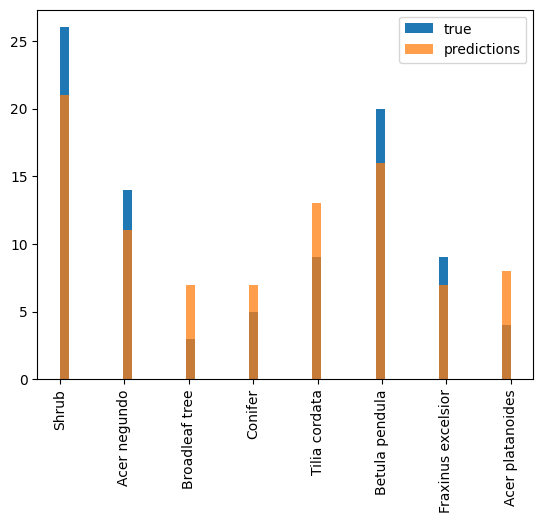

In [30]:
# plt.subplots(1, 2, sharex=True, figsize=(12, 6))
plt.hist(trues, bins=50, label="true")
plt.hist(preds, bins=50, label="predictions", alpha=0.75)
plt.xticks(ticks=range(len(data.label_map)), labels=list(data.label_map.keys()), rotation=90)
plt.legend()
plt.show()

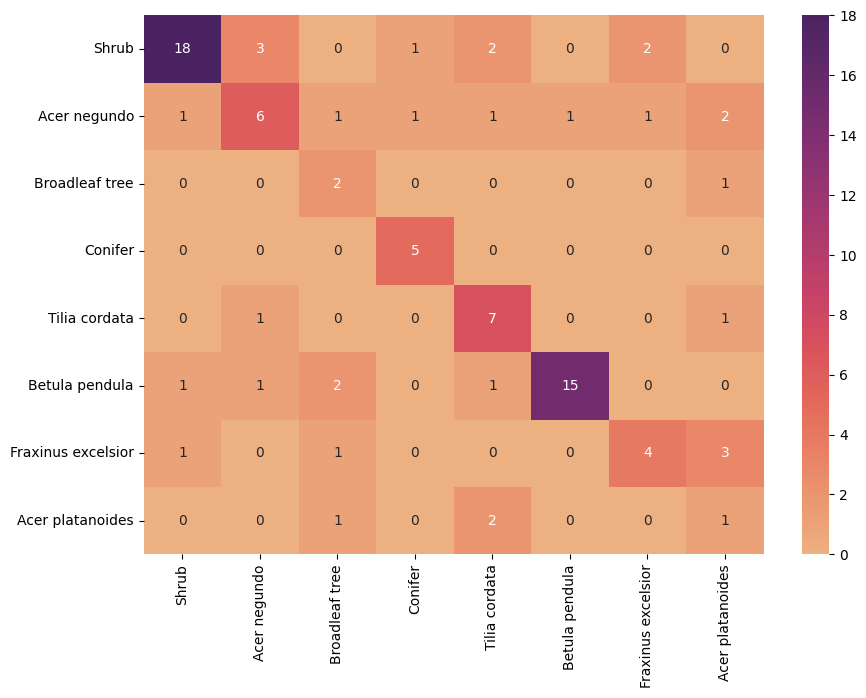

In [31]:
df_cm = pd.DataFrame(confusion_matrix(trues, preds), index=data.label_map.keys(), columns=data.label_map.keys())
plt.figure(figsize = (10, 7))
sns.heatmap(df_cm, cmap="flare", annot=True)
plt.show()

In [32]:
#!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
#!pip install pypandoc
#!jupyter nbconvert --to pdf /content/ResNetClf.ipynb